# Analysis of Number of CPUs on Memory

Note, to generate the serialized objects used in this analysis, you will need to navigate to this directory and run the following command:
```sh
sudo <path to julia> script.jl
```

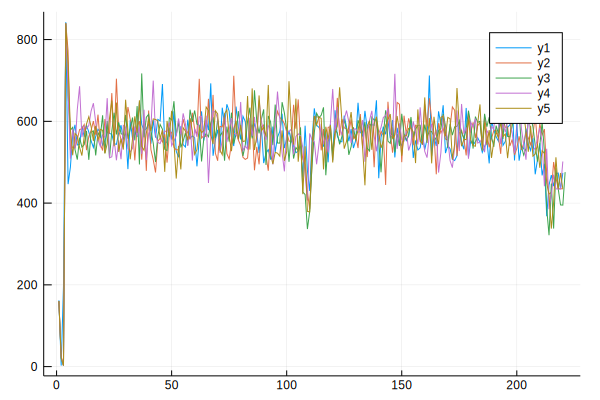

In [9]:
# Set up environment from Launcher
using Pkg
Pkg.activate("../../Launcher")
using Serialization

using Launcher, MemSnoop, Plots

trackers = open(deserialize, "cnn_cpu_sweep.jls")

# Convenience Functions
size_mb(x) = 4 * x / 1024

plot([size_mb.(t.active_pages) for t in trackers])